In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
torch.manual_seed(0)

In [2]:
data = pd.read_csv("amazon_cells_labelled.txt", sep="\t", header=None)
reviews = data.iloc[:,0].str.lower()
sentiment = data.iloc[:,1].values

In [3]:
for i in punctuation:
    reviews = reviews.str.replace(i,"")

In [4]:
words = ' '.join(reviews)
words = words.split()
vocabulary = set(words)
indexer = {word: index for (index, word) in enumerate(vocabulary)}

In [5]:
indexed_reviews = []
for review in reviews:
    indexed_reviews.append([indexer[word] for word in review.split()])

In [6]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, n_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.output(out)
        out = out[-1,0]
        out = torch.sigmoid(out)
        
        return out

In [7]:
model = LSTM(len(vocabulary), 64, 128, 3)
model

LSTM(
  (embedding): Embedding(1905, 64)
  (lstm): LSTM(64, 128, num_layers=3, batch_first=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)

In [8]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [9]:
losses = []
acc = []
for e in range(1, epochs+1):
    single_loss = []
    preds = []
    targets = []
    for i, r in enumerate(indexed_reviews):
        if len(r) <= 1:
            continue
        x = torch.Tensor([r]).long()
        y = torch.Tensor([sentiment[i]])
    
        pred = model(x)
        loss = loss_function(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        final_pred = np.round(pred.detach().numpy())
        preds.append(final_pred)
        targets.append(y)
        single_loss.append(loss.item())
        
    losses.append(np.mean(single_loss))
    accuracy = accuracy_score(targets,preds)
    acc.append(accuracy)
    if e%1 == 0:
        print("Epoch: ", e, "... Loss function: ", losses[-1], "... Accuracy: ", acc[-1])

c:\users\hyatt\envs\packt\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:  1 ... Loss function:  0.6380536617880773 ... Accuracy:  0.6388329979879276
Epoch:  2 ... Loss function:  0.5032742530467285 ... Accuracy:  0.7676056338028169
Epoch:  3 ... Loss function:  0.34702016431997557 ... Accuracy:  0.8601609657947686
Epoch:  4 ... Loss function:  0.22138979686891438 ... Accuracy:  0.9195171026156942
Epoch:  5 ... Loss function:  0.10564509996370719 ... Accuracy:  0.9668008048289738
Epoch:  6 ... Loss function:  0.10437952617997122 ... Accuracy:  0.9668008048289738
Epoch:  7 ... Loss function:  0.0751589212587593 ... Accuracy:  0.9758551307847082
Epoch:  8 ... Loss function:  0.03808908871542737 ... Accuracy:  0.9869215291750503
Epoch:  9 ... Loss function:  0.0034994612931080575 ... Accuracy:  1.0
Epoch:  10 ... Loss function:  0.00042380886661959896 ... Accuracy:  1.0


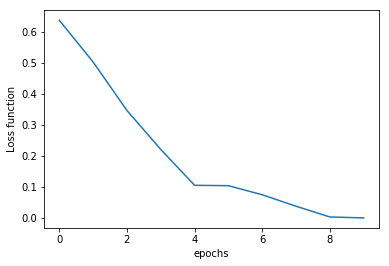

In [10]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.show()

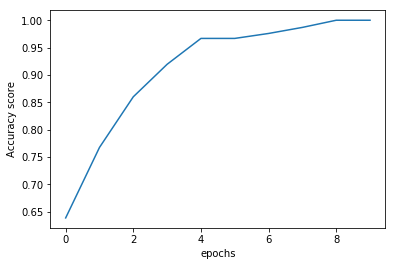

In [11]:
x_range = range(len(acc))
plt.plot(x_range, acc)
plt.xlabel("epochs")
plt.ylabel("Accuracy score")
plt.show()